# OUR COMPANY: ETC - ENTERPRISE TRAINING CENTER

*ETC offers training courses about all kinds of IT-related topics in three Austrian cities. Their portfolio comprises among other topics: Microsoft (Office), cisco, Oracle, IBM, Linux, Social Media, IT-Security and Adobe. The data that we collected reaches back to the year 2007. Our analysis' main focus is on the number of participants registered for the courses and on the cancellation dates of the courses. What we want to find out is if we can obtain a prediction about the final number of participants in advance. This information is crucial to the company, since they often have to cancel courses due to insufficient registration numbers.*

**Introduction**

For our data analysis we use two tables. The first table shows in the column “StornoDatum” which courses have been cancelled. The other table shows another column “StornoDatum”, which refers to each course participant who decided to deregister from the course after already being registered.

Then, we also have the column "TerminFix": It shows if the company can guarantee that a course will take place, due to sufficient participant registrations. "VorstufeTG": Only one more participant is missing until a course it guaranteed


In [136]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.model_selection import KFold
import numpy as np
%matplotlib inline

In [137]:
data_register = pd.read_csv("Seminardaten_Teilnehmer.csv", header=0, sep=";",
                           infer_datetime_format=True, parse_dates=[1, 2], dayfirst=True)
data_register.head()

,SeminarID,AnmeldeDatum,StornoDatum
0,1723,30.11.1998 00:00,nan
1,1723,30.11.1998 00:00,nan
2,1857,13.01.1999 00:00,nan
3,1964,18.05.1999 00:00,nan
4,2025,18.05.1999 00:00,nan


In [138]:
# convert to datetime
data_register.AnmeldeDatum = pd.to_datetime(data_register.AnmeldeDatum, errors="coerce",
                                            dayfirst=True, infer_datetime_format=True)
data_register.StornoDatum = pd.to_datetime(data_register.StornoDatum, errors="coerce",
                                           dayfirst=True, infer_datetime_format=True)

In [139]:
data = pd.read_csv("Seminardaten.csv", index_col=2, header=0, sep=";",
                   true_values=["WAHR"], false_values=["FALSCH"], encoding ="utf-8", 
                   infer_datetime_format=True, parse_dates=[5, 6, 7, 14, 16, 17], dayfirst=True)
data.StornoDatum = pd.to_datetime(data.StornoDatum, errors = "coerce", dayfirst = True, infer_datetime_format=True)
data.head()

,Gruppe,Bereich,SeminarStammID,Titel,Produktanlagedatum,DatumVon,DatumBis,Dauer,Feiertage,AnzahlTN,...,StornoDatum,StornoGrund,ErstellungTermin,ŽnderungTermin,ForeignID,Fakturiert,Mandant,Typ,TerminFix,VorstufeTG
SeminarID,,,,,,,,,,,,,,,,,,,,,
3145,Weitere Themen,Specials,ECT3,eCommerce Technologies fr das Management,2000-10-31 09:32:00,2000-11-23,2000-11-23,NaN,NaN,2.0,...,2000-11-17,zuwenig TN,2000-10-31 09:32:00,2016-01-19 09:25:00,NaN,False,3.0,S,False,False
3157,Weitere Themen,Specials,O-NETSEC,"Networking, TCP/IP und Security",1999-07-27 15:04:00,2000-12-11,2000-12-15,5,0,NaN,...,2000-11-29,TN-Mangel,2000-11-09 10:37:00,2016-01-19 09:25:00,NaN,False,3.0,S,False,False
3154,Weitere Themen,Specials,ECT3,eCommerce Technologies fr das Management,2000-10-31 09:32:00,2000-12-14,2000-12-14,1,0,0.0,...,2000-12-04,TN-Mangel,2000-11-06 09:59:00,2016-03-07 08:12:00,NaN,False,3.0,S,False,False
3140,NaN,Microsoft-Backoffice,MOC2152,Supporting Windows 2000 Professional & Server,1999-01-04 11:54:00,2000-12-18,2000-12-22,5,0,0.0,...,2000-11-29,TN-Mangel,2000-10-30 23:41:00,2016-03-07 08:12:00,NaN,False,3.0,S,False,False
3158,NaN,Microsoft-Backoffice,MOC2153,Supporting a Windows 2000 Network Infrastructure,1999-07-12 13:57:00,2001-01-15,2001-01-19,5,0,NaN,...,2000-12-19,JK: Keine TN,2000-11-09 13:18:00,2016-01-19 09:25:00,NaN,False,3.0,S,False,False


In [140]:
# how long in advance a course gets created?
(data['DatumVon'] - data['ErstellungTermin']).describe()

count                         27179
mean     -177 days +06:01:48.379263
std       1063 days 10:05:54.273680
min            -4444 days +12:53:00
25%                58 days 12:53:00
50%               187 days 09:42:00
75%               284 days 01:38:30
max               677 days 05:47:00
dtype: object

In [141]:
# how many days before a course it gets cancelled?
(data['DatumVon'] - data['StornoDatum']).describe()

count                       15038
mean       6 days 03:16:28.076871
std      119 days 08:11:39.449405
min          -3652 days +00:00:00
25%               0 days 00:00:00
50%              14 days 00:00:00
75%              18 days 00:00:00
max            5849 days 00:00:00
dtype: object

Then, we calculate the “daysDiff” which shows how many days in advance a participant has registered before the course starts. So, if a participant registered on Sept 5th and the course starts on Sept 10th, then the value for daysDiff is 5 days.

In [142]:
# filter registrations only and calculate the days, the participant registered in advance

data_registrations = data_register[['SeminarID', 'AnmeldeDatum']].merge(
    data[['DatumVon']], 
    left_on = 'SeminarID', 
    right_index = True,
    how = 'right'
)
data_registrations['daysDiff'] = (data_registrations['DatumVon'] - 
                                  data_registrations['AnmeldeDatum']).astype('timedelta64[D]')
data_registrations.head()

,SeminarID,AnmeldeDatum,DatumVon,daysDiff
5,13053,2010-09-15 09:24:00,2010-09-13,-3.0
4747,13053,2010-06-11 10:41:00,2010-09-13,93.0
4748,13053,2010-06-14 12:49:00,2010-09-13,90.0
4758,13053,2010-09-08 16:31:00,2010-09-13,4.0
4763,13053,2010-07-30 15:26:00,2010-09-13,44.0


The table below shows the same calculation, only focusing on the days a participants decides to deregister from the course before the actual course starts.

In [143]:
# filter cancellations only and calculate the days, the participant registered in advance

data_cancellations = data_register[['SeminarID', 'StornoDatum']].merge(
    data[['DatumVon']], 
    left_on = 'SeminarID', 
    right_index = True,
    how = 'right'
)
data_cancellations['daysDiff'] = (data_cancellations['DatumVon'] - 
                                  data_cancellations['StornoDatum']).astype('timedelta64[D]')
data_cancellations.head()

,SeminarID,StornoDatum,DatumVon,daysDiff
5,13053,NaT,2010-09-13,NaN
4747,13053,NaT,2010-09-13,NaN
4748,13053,NaT,2010-09-13,NaN
4758,13053,NaT,2010-09-13,NaN
4763,13053,NaT,2010-09-13,NaN


In [144]:
# When do participants typically register?

data_registrations['daysDiff'].describe()

count    59964.000000
mean        46.813305
std         47.971034
min      -1824.000000
25%         16.000000
50%         34.000000
75%         66.000000
max       1116.000000
Name: daysDiff, dtype: float64

For the next analysis, we decided to add a feature. (R.. columns) We figured out that the courses are usually created around 187 days (mean value) before they take place and we decided to look at the number of course registrations (or participants) in 7-days intervals until the actual course start. As a start date, we choose 182 days (because it can be divided by 7 without residual) before the course start and we are now going to add a column for the current number of participants in 7-days step until we reach the courses’ start dates. The most right column (R) represents the number of final participants.

In [145]:
from datetime import datetime, timedelta
for x in range (182, 0, -7):
    # calculate registrations at the point in time
    
    reg_count = data_registrations[
        data_registrations['daysDiff'] > x
    ].groupby('SeminarID').count()[['AnmeldeDatum']]

    # calculate cancellations at the point in time
    
    can_count = data_cancellations[
            data_cancellations['daysDiff'] > x
    ].groupby('SeminarID').count()[['StornoDatum']]

    # join registrations and cancellations
    
    data_registrations_cancellations = reg_count.merge(
        can_count,
        how = 'left',
        left_index = True,
        right_index = True
    ).fillna(0)
    
    # calculate net registrations
    
    data_registrations_net = data_registrations_cancellations['AnmeldeDatum'] - data_registrations_cancellations['StornoDatum']
    
    # add
    
    data['R' + str(x)] = data_registrations_net

reg_count = data_registrations_cancellations = data_registrations.groupby('SeminarID').count()[['AnmeldeDatum']]
can_count = data_cancellations.groupby('SeminarID').count()[['StornoDatum']]
data_registrations_cancellations = reg_count.merge(
    can_count,
    how = 'left',
    left_index = True,
    right_index = True
).fillna(0)
data_registrations_net = data_registrations_cancellations['AnmeldeDatum'] - data_registrations_cancellations['StornoDatum']
data['R'] = data_registrations_net
data.head()

,Gruppe,Bereich,SeminarStammID,Titel,Produktanlagedatum,DatumVon,DatumBis,Dauer,Feiertage,AnzahlTN,...,R63,R56,R49,R42,R35,R28,R21,R14,R7,R
SeminarID,,,,,,,,,,,,,,,,,,,,,
3145,Weitere Themen,Specials,ECT3,eCommerce Technologies fr das Management,2000-10-31 09:32:00,2000-11-23,2000-11-23,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0,2
3157,Weitere Themen,Specials,O-NETSEC,"Networking, TCP/IP und Security",1999-07-27 15:04:00,2000-12-11,2000-12-15,5,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3154,Weitere Themen,Specials,ECT3,eCommerce Technologies fr das Management,2000-10-31 09:32:00,2000-12-14,2000-12-14,1,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3140,NaN,Microsoft-Backoffice,MOC2152,Supporting Windows 2000 Professional & Server,1999-01-04 11:54:00,2000-12-18,2000-12-22,5,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3158,NaN,Microsoft-Backoffice,MOC2153,Supporting a Windows 2000 Network Infrastructure,1999-07-12 13:57:00,2001-01-15,2001-01-19,5,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [146]:
data.columns[23:]

Index(['R182', 'R175', 'R168', 'R161', 'R154', 'R147', 'R140', 'R133', 'R126',
       'R119', 'R112', 'R105', 'R98', 'R91', 'R84', 'R77', 'R70', 'R63', 'R56',
       'R49', 'R42', 'R35', 'R28', 'R21', 'R14', 'R7', 'R'],
      dtype='object')

In [147]:
data[data.columns[23:]] = data[data.columns[23:]].fillna(0)

In [148]:
data.columns[0:24]

Index(['Gruppe', 'Bereich', 'SeminarStammID', 'Titel', 'Produktanlagedatum',
       'DatumVon', 'DatumBis', 'Dauer', 'Feiertage', 'AnzahlTN', 'TrainerID',
       'Zeugnis', 'ZeugnisArt', 'StornoDatum', 'StornoGrund',
       'ErstellungTermin', 'ŽnderungTermin', 'ForeignID', 'Fakturiert',
       'Mandant', 'Typ', 'TerminFix', 'VorstufeTG', 'R182'],
      dtype='object')

In [149]:
# we use colum 'R' now
data = data.drop(['AnzahlTN'], axis = 1)

In [150]:
data.head()

,Gruppe,Bereich,SeminarStammID,Titel,Produktanlagedatum,DatumVon,DatumBis,Dauer,Feiertage,TrainerID,...,R63,R56,R49,R42,R35,R28,R21,R14,R7,R
SeminarID,,,,,,,,,,,,,,,,,,,,,
3145,Weitere Themen,Specials,ECT3,eCommerce Technologies fr das Management,2000-10-31 09:32:00,2000-11-23,2000-11-23,NaN,NaN,7529.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2
3157,Weitere Themen,Specials,O-NETSEC,"Networking, TCP/IP und Security",1999-07-27 15:04:00,2000-12-11,2000-12-15,5,0,4842.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3154,Weitere Themen,Specials,ECT3,eCommerce Technologies fr das Management,2000-10-31 09:32:00,2000-12-14,2000-12-14,1,0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3140,NaN,Microsoft-Backoffice,MOC2152,Supporting Windows 2000 Professional & Server,1999-01-04 11:54:00,2000-12-18,2000-12-22,5,0,185.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3158,NaN,Microsoft-Backoffice,MOC2153,Supporting a Windows 2000 Network Infrastructure,1999-07-12 13:57:00,2001-01-15,2001-01-19,5,0,7529.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Then we are continuing with some exploratory analysis. In row 15, the mean value of the number of participants per course is 2, due to the fact, that many courses have 0 participants. Furthermore, the maximum number found in a course is 186, which is probably one of the few bigger trainings they offer.

In [151]:
data['R'].describe()

count    27181.000000
mean         2.011515
std          4.727557
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max        186.000000
Name: R, dtype: float64

Here in row 17, we have depicted all the R.. columns for the current participant number for each 7-day interval in relation to the final number and predicted the probability of the current number already being the final number of participants. The X-Axis shows the current registrations and the Y-Axis represents the final number of participants. What we can obviously observe here, is that the prediction of the total number of participants in advance gets closer to 1 over time.

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_86\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


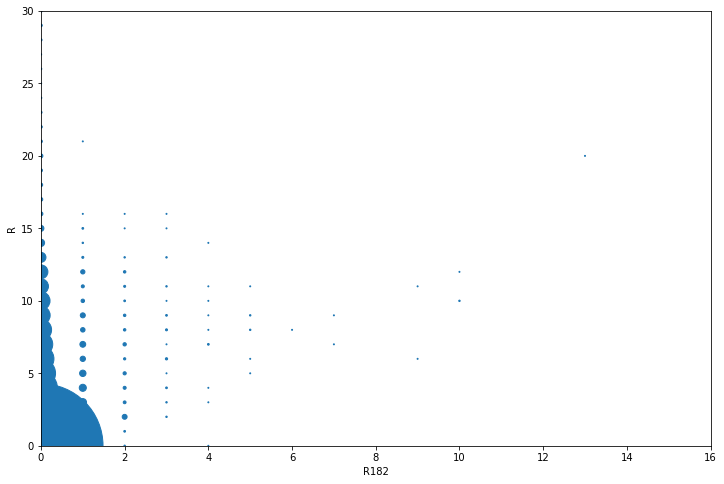

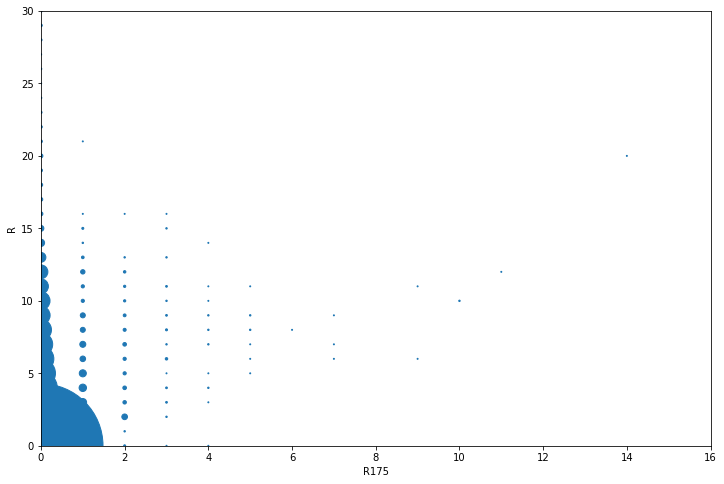

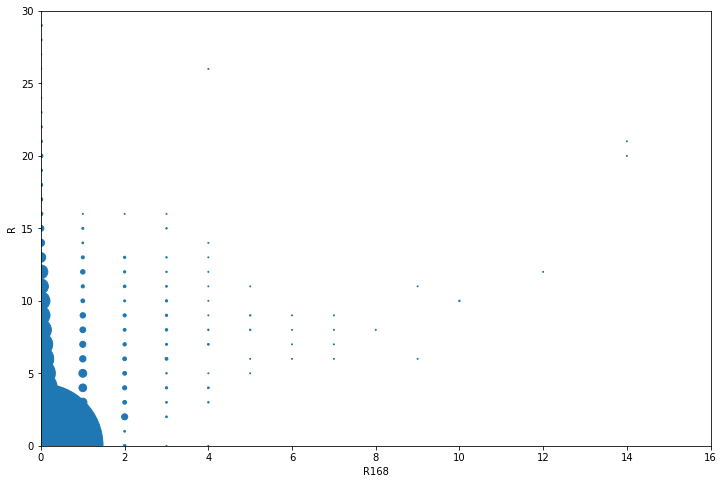

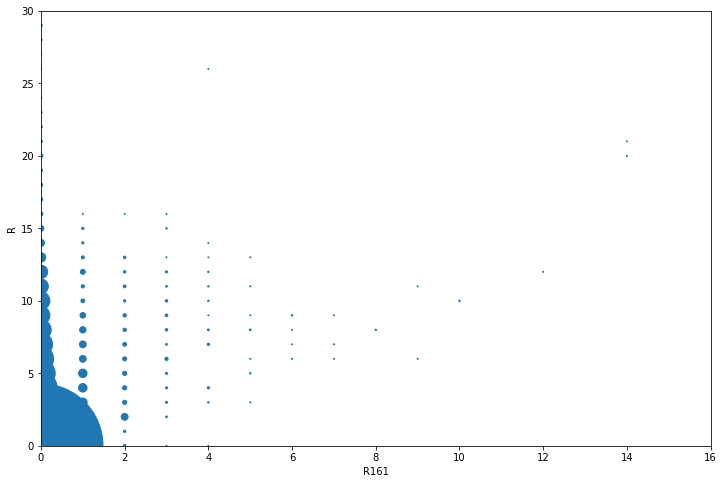

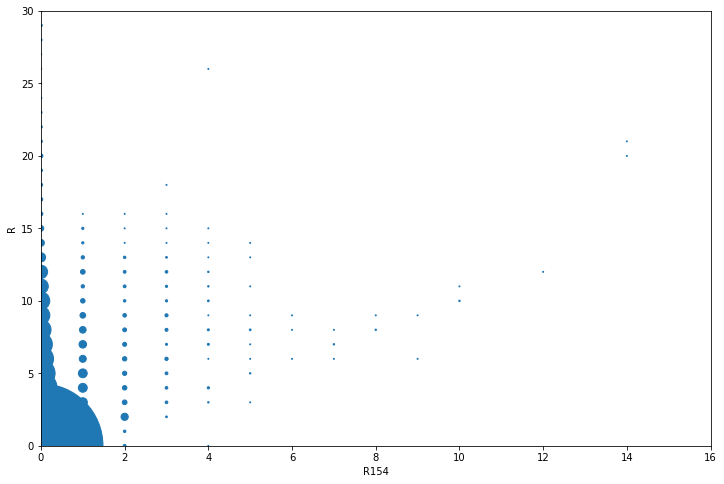

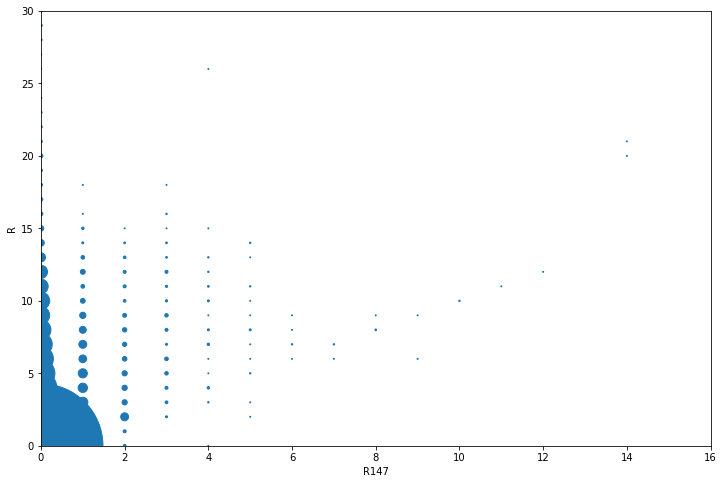

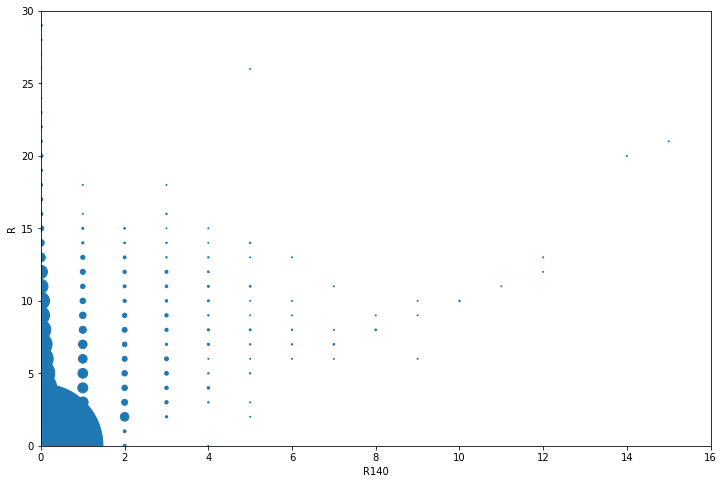

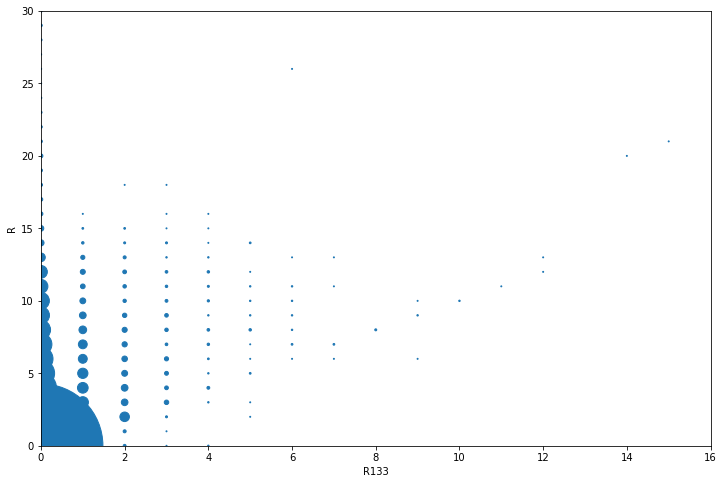

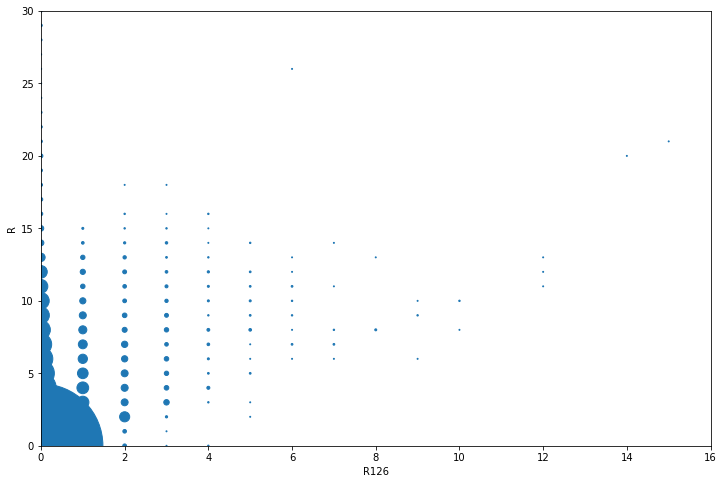

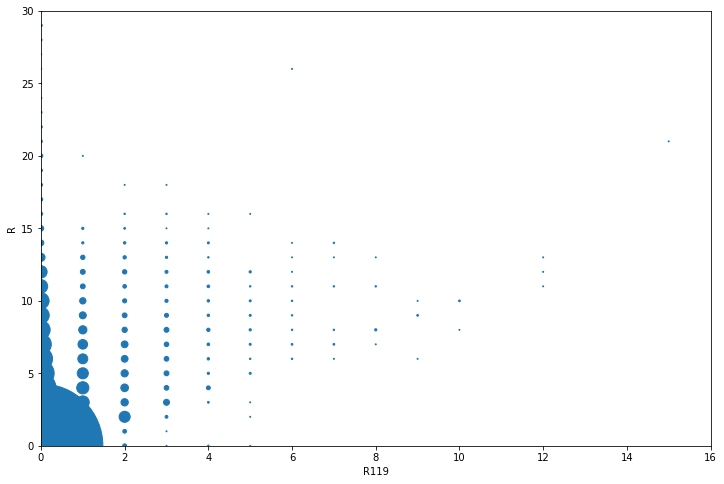

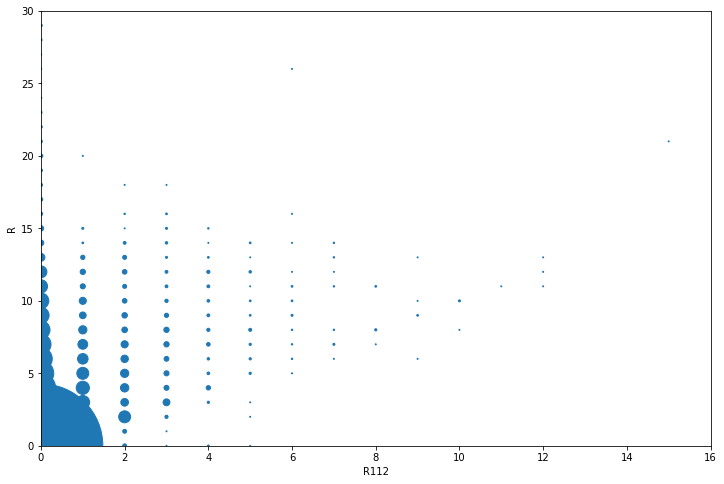

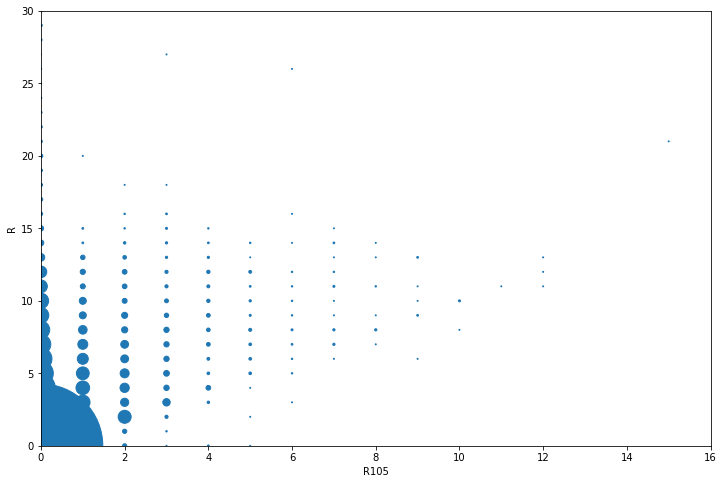

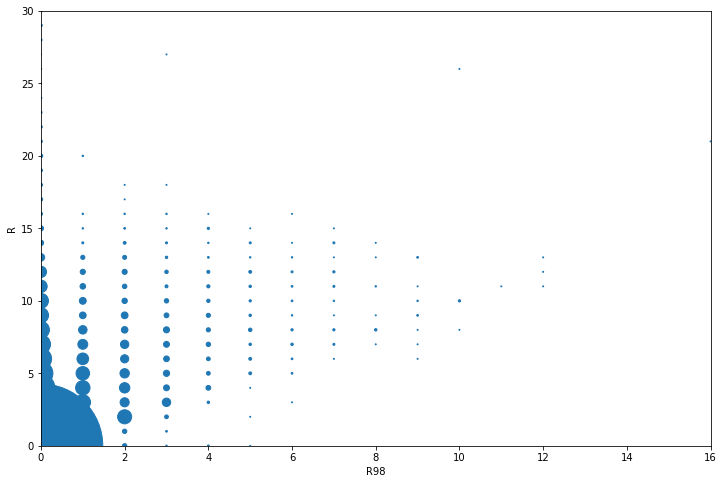

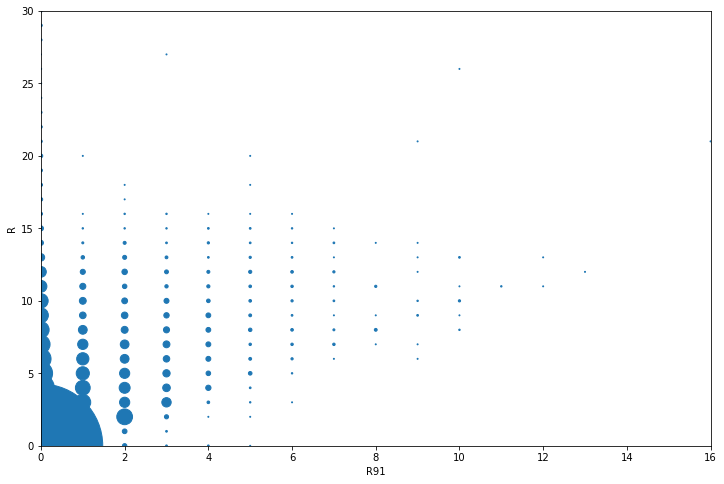

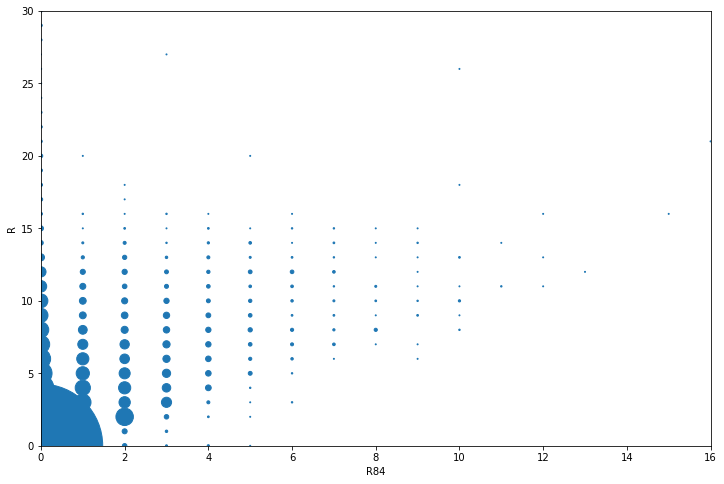

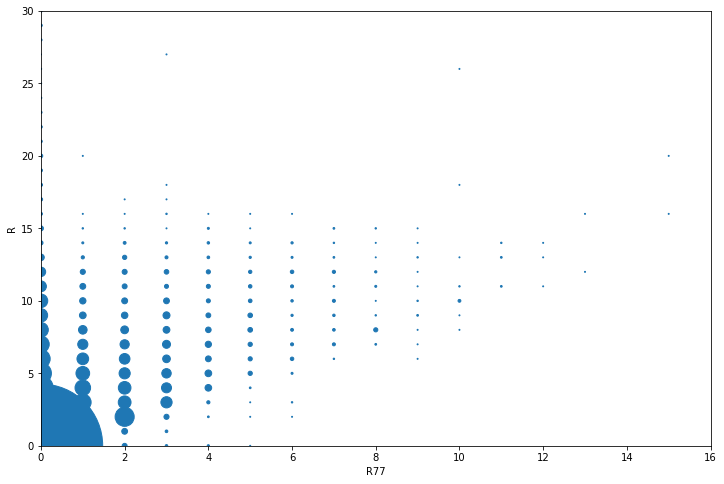

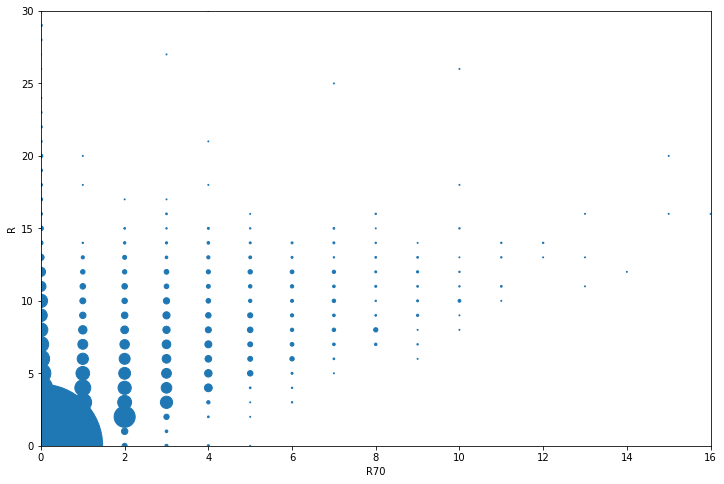

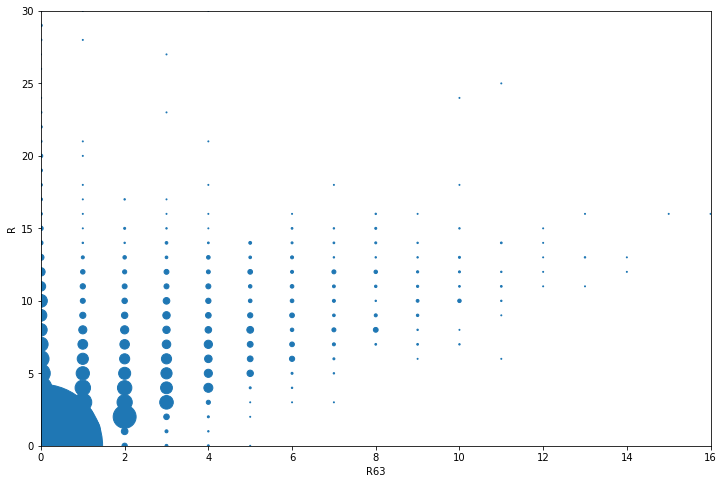

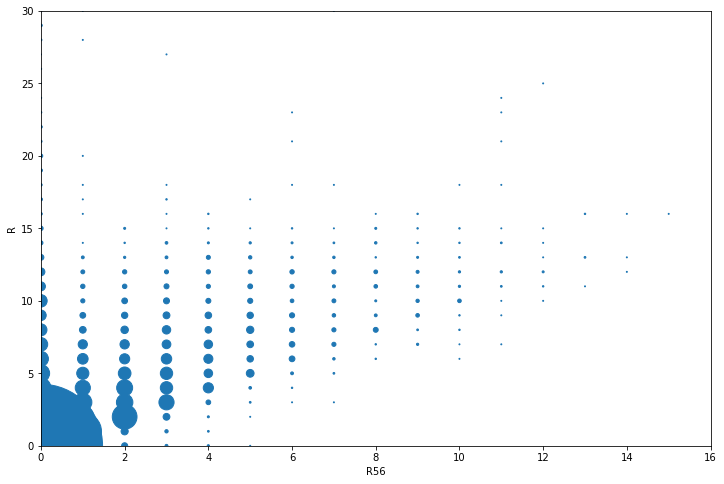

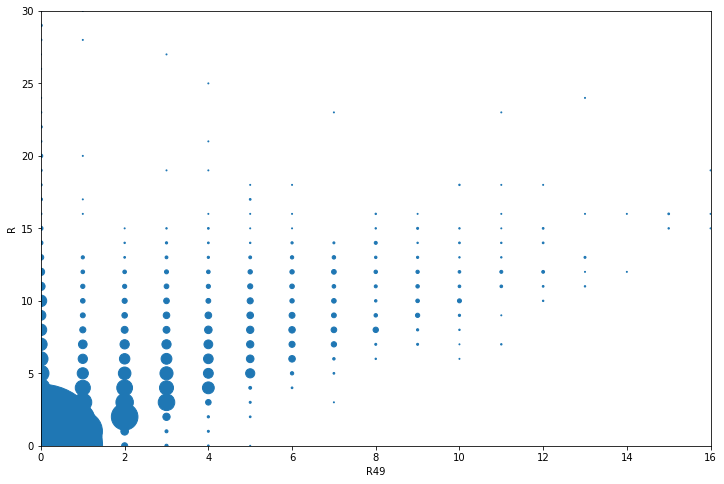

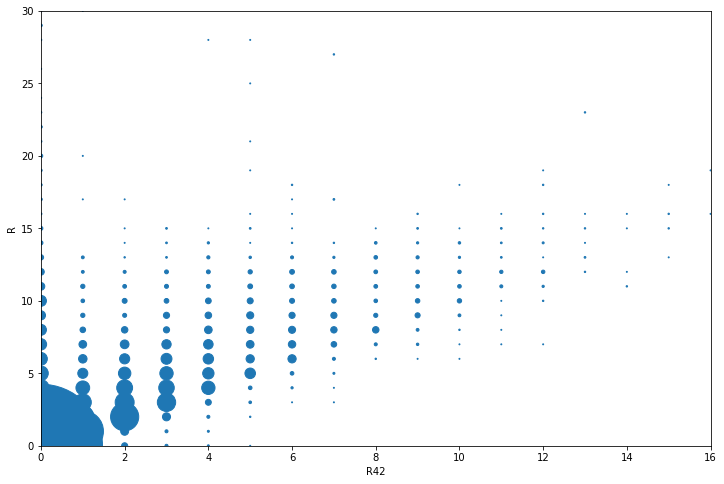

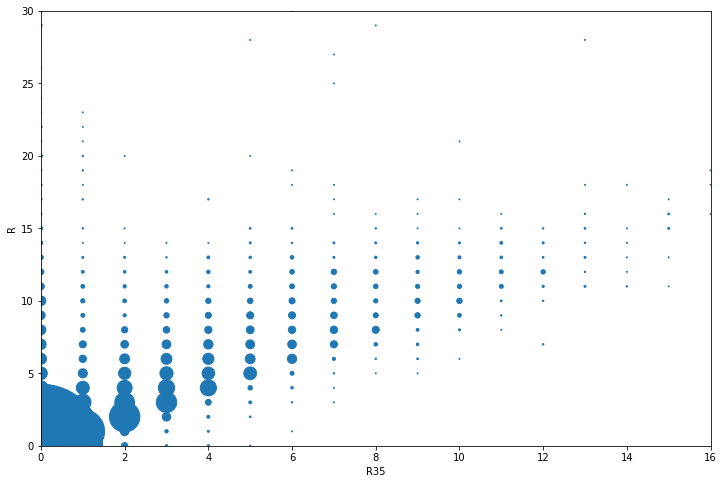

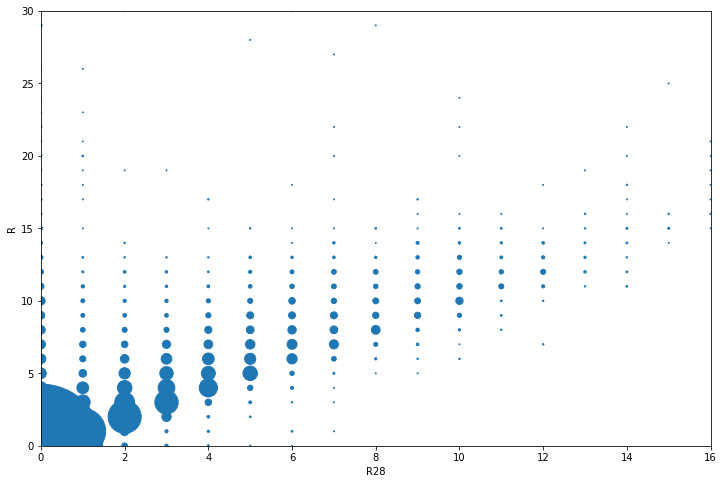

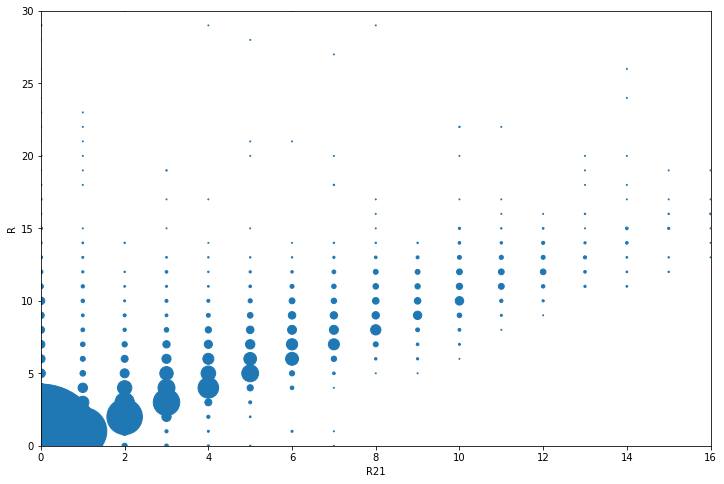

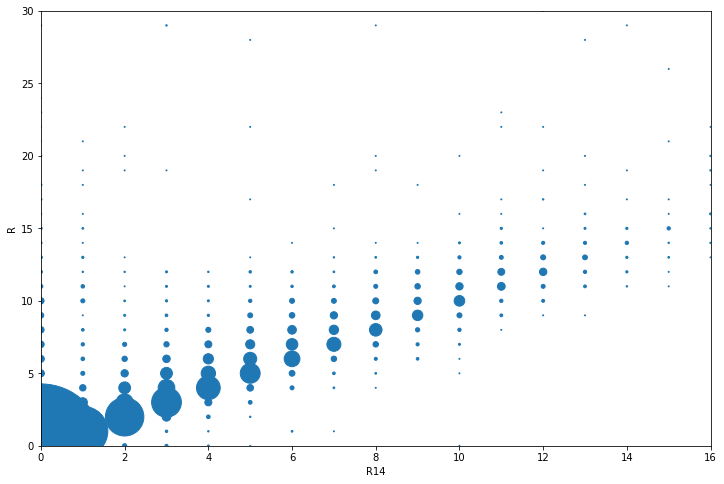

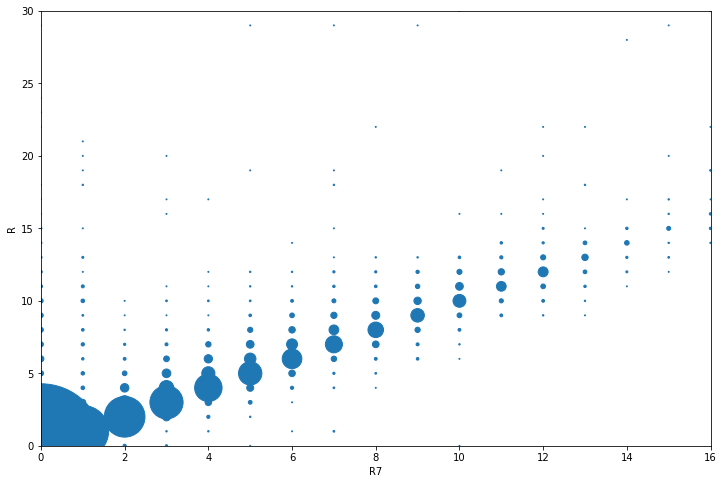

In [152]:
for x in range (182, 0, -7):
    R_ = 'R' + str(x)
    data_count = data[[R_, 'R', 'DatumVon']].groupby([R_, 'R']).count()
    data_count = data_count.reset_index()
    data_count.plot.scatter(R_, 'R', xlim = [0, 16], ylim = [0, 30], figsize = [12, 8], s = data_count['DatumVon'])

In [153]:
# an example for different Titles with same SeminarStammID
groups = data.groupby(['SeminarStammID'])
groups.Titel.unique()[3]

array(['Update from Microsoft Windows 2000 to Microsoft Windows Server 2003',
       'Windows Server 2000 "upgrade" Kurs auf Windows Server 2003'], dtype=object)

In [154]:
len(data.SeminarStammID.unique())
# => I would drop 'Titel' column since it is encoded in 'SeminarStammID'

2817

In [155]:
data = data.drop(['Titel'], axis=1)

In [156]:
# We were told older data is less clean
data = data[data.DatumVon > "2008-01-01"]

In [157]:
# add a column that marks canceled seminars with 1.
data['Storno'] = np.ones(len(data))
data.loc[pd.isnull(data.StornoDatum), 'Storno'] = 0.

In [158]:
data.columns

Index(['Gruppe', 'Bereich', 'SeminarStammID', 'Produktanlagedatum', 'DatumVon',
       'DatumBis', 'Dauer', 'Feiertage', 'TrainerID', 'Zeugnis', 'ZeugnisArt',
       'StornoDatum', 'StornoGrund', 'ErstellungTermin', 'ŽnderungTermin',
       'ForeignID', 'Fakturiert', 'Mandant', 'Typ', 'TerminFix', 'VorstufeTG',
       'R182', 'R175', 'R168', 'R161', 'R154', 'R147', 'R140', 'R133', 'R126',
       'R119', 'R112', 'R105', 'R98', 'R91', 'R84', 'R77', 'R70', 'R63', 'R56',
       'R49', 'R42', 'R35', 'R28', 'R21', 'R14', 'R7', 'R', 'Storno'],
      dtype='object')

In [159]:
# drop useless columns (Trainer is not known to customers)
data = data.drop(['Produktanlagedatum', 'TrainerID', 'StornoDatum', 'StornoGrund', 'ErstellungTermin', 'ŽnderungTermin', 'TerminFix', 'Fakturiert'], axis=1)

In [160]:
# generalize capitalization
data.Gruppe = data.Gruppe.str.lower()
data.Bereich = data.Bereich.str.lower()

In [161]:
data.Gruppe.unique()
# keep

array(['microsoft', 'cisco', nan, 'weitere themen', 'oracle',
       'office academy', 'it-management', 'red hat', 'partnerseminare',
       'hp', 'vmware', 'citrix', 'miete', 'security', 'ibm', 'aws'], dtype=object)

In [162]:
data.Bereich.unique()
# keep

array(['development', 'cisco-routing-and-switching',
       'microsoft-backoffice', 'exchange-und-lync', 'sharepoint',
       'windows-server', 'sql-server', 'sharepoint-2010', 'windows-7',
       'vmware', 'ms-partnertraining', 'windows-server-2008-r2',
       'oracle-datenbank', 'security', 'microsoft',
       'weitere-office-produkte', 'cisco', 'windows-server-2016', 'itil',
       'unix', 'dynamics-ax', 'system-center', 'partnerseminare',
       'cisco-weitere-themen', 'windows-server-2012-(r2)', 'red hat',
       'biztalk-server', 'windows-client', 'netzwerk', 'java',
       'weitere-themen', 'pers”nlichkeit', 'dynamics', 'jboss',
       'software development', 'prince2', 'oracle-middleware',
       'e-learning', 'hp', 'axapta', 'red hat-enterprise linux',
       'windows-7/8', 'data center virtualisierung', 'cisco-security',
       'citrix', 'microsoft-outlook', 'moc', 'grafik', 'specials',
       'cisco-datacenter', 'dynamics-crm', 'intern',
       'citrix-virtualisierung', 'che

In [163]:
# how many different SeminarStammIDs do we have?
len(data.SeminarStammID.unique())

2129

In [164]:
# this cannot be used as feature, would lead to way to many columns
data = data.drop(['SeminarStammID'], axis=1)

In [165]:
data.Dauer.unique()

array(['5', '3', '2', '1', '4', '0', '10', '9', '1,5', '38', '2,5', '17',
       '12', '3,5', '31', '0,5', '13', '32', '15', '0,45', '0,62', '26',
       nan, '6', '27', '39', '8', '14'], dtype=object)

In [166]:
len(data.loc[pd.isnull(data.Dauer)])

1

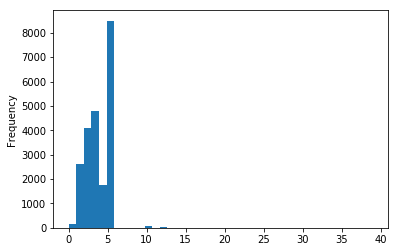

In [167]:
data.Dauer = pd.to_numeric(data.Dauer.str.replace(',', '.'))
data.Dauer.plot('hist', bins=40)
# most between 1 and 5
# seems viable

In [168]:
data.ForeignID.unique()
# => useless

array([ nan])

In [169]:
data = data.drop(['ForeignID'], axis=1)

In [170]:
data.Feiertage.unique()

array(['0', '1', '94', '0,5', '2', nan, '64', '3', '60', '13', '4', '67',
       '35'], dtype=object)

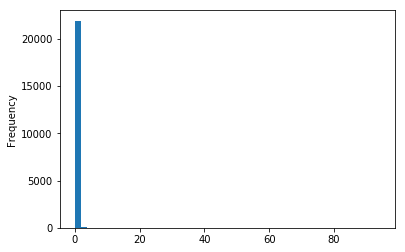

In [171]:
pd.to_numeric(data.Feiertage.str.replace(',', '.')).plot(kind='hist', bins=50)
# => not very meaningfull => drop

In [172]:
data = data.drop(['Feiertage'], axis=1)

In [173]:
data.Mandant.unique()

array([ 3.,  4.,  1.,  2.])

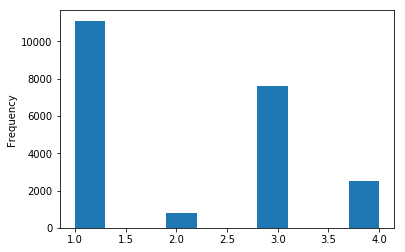

In [174]:
data.Mandant.plot(kind='hist', bins=10)
# => seems meaningfull, but not sure what it is and vaguely remember that in the meeting it was said
# that it is not a helpfull feature => remove for now

In [175]:
data = data.drop(['Mandant'], axis=1)

In [176]:
data.Zeugnis.unique()
# => useless

array([False], dtype=bool)

In [177]:
data = data.drop(['Zeugnis'], axis=1)

In [178]:
data.ZeugnisArt.unique()
# => useless

array([nan, 'Microsoft'], dtype=object)

In [179]:
data = data.drop(['ZeugnisArt'], axis=1)

In [180]:
data.Typ.unique()

array(['S', 'K'], dtype=object)

In [181]:
data.groupby(['Typ']).count()
# => seems to be only a few special cases => drop

,Gruppe,Bereich,DatumVon,DatumBis,Dauer,VorstufeTG,R182,R175,R168,R161,...,R56,R49,R42,R35,R28,R21,R14,R7,R,Storno
Typ,,,,,,,,,,,,,,,,,,,,,
K,30,38,38,38,38,38,38,38,38,38,...,38,38,38,38,38,38,38,38,38,38
S,21259,21962,21962,21960,21961,21962,21962,21962,21962,21962,...,21962,21962,21962,21962,21962,21962,21962,21962,21962,21962


In [182]:
data = data.drop(['Typ'], axis=1)

In [183]:
data.VorstufeTG.unique()

array([False,  True], dtype=bool)

In [184]:
data.groupby(['VorstufeTG']).count()
# => seems to be only a few special cases => drop

,Gruppe,Bereich,DatumVon,DatumBis,Dauer,R182,R175,R168,R161,R154,...,R56,R49,R42,R35,R28,R21,R14,R7,R,Storno
VorstufeTG,,,,,,,,,,,,,,,,,,,,,
False,21174,21883,21883,21881,21882,21883,21883,21883,21883,21883,...,21883,21883,21883,21883,21883,21883,21883,21883,21883,21883
True,115,117,117,117,117,117,117,117,117,117,...,117,117,117,117,117,117,117,117,117,117


In [185]:
data = data.drop(['VorstufeTG'], axis=1)

In [186]:
# check out remaining NaNs
data[data.isnull().any(axis=1)]

,Gruppe,Bereich,DatumVon,DatumBis,Dauer,R182,R175,R168,R161,R154,...,R56,R49,R42,R35,R28,R21,R14,R7,R,Storno
SeminarID,,,,,,,,,,,,,,,,,,,,,
10547,NaN,microsoft-backoffice,2008-01-07,2008-01-08,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
10164,NaN,windows-server,2008-01-14,2008-01-16,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
9961,NaN,windows-server,2008-01-14,2008-01-18,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
9963,NaN,sharepoint-2010,2008-01-14,2008-01-15,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
10049,NaN,windows-7,2008-01-14,2008-01-15,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
9852,NaN,windows-server,2008-01-14,2008-01-18,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
9866,NaN,sharepoint-2010,2008-01-14,2008-01-15,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,5.0,5.0,6.0,10,0.0
9867,NaN,sharepoint-2010,2008-01-16,2008-01-17,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,5.0,5.0,8.0,9,0.0
9964,NaN,sharepoint-2010,2008-01-16,2008-01-18,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0


In [187]:
# 'Gruppe' seems to be the main reason 
# => create a new label for no 'Gruppe'
data.loc[pd.isnull(data.Gruppe), 'Gruppe'] = "keine Gruppe"

In [188]:
# check out remaining NaNs
data[data.isnull().any(axis=1)]

,Gruppe,Bereich,DatumVon,DatumBis,Dauer,R182,R175,R168,R161,R154,...,R56,R49,R42,R35,R28,R21,R14,R7,R,Storno
SeminarID,,,,,,,,,,,,,,,,,,,,,
15515,microsoft,windows-7/8,2012-05-29 00:00:00,NaT,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
20053,microsoft,windows-server-2008-r2,2014-06-10 00:00:00,NaT,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
54882,office academy,microsoft-powerpoint,2015-11-11 09:00:00,2015-11-12,NaN,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0


In [189]:
# => just drop these rows
data = data.dropna()

In [190]:
# we dont really need two dates (length of seminar is encoded in 'Dauer' anyway)
data = data.drop(['DatumBis'], axis=1)

In [191]:
# create a new colum representing the time of the year with a cosine value
data['Timeofyear'] = np.cos((2*np.pi*data.DatumVon.dt.day)/365.)

In [192]:
# also create quarter, for incorporation of economic growth data later

data['Quartal'] = data.DatumVon.dt.year.map(str) + 'Q' + data.DatumVon.dt.quarter.map(str)

In [193]:
data.head()

,Gruppe,Bereich,DatumVon,Dauer,R182,R175,R168,R161,R154,R147,...,R42,R35,R28,R21,R14,R7,R,Storno,Timeofyear,Quartal
SeminarID,,,,,,,,,,,,,,,,,,,,,
9857,microsoft,development,2008-01-07 00:00:00,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0,1.0,0.992749,2008Q1
10241,cisco,cisco-routing-and-switching,2008-01-07 00:00:00,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,3.0,3.0,3.0,3,0.0,0.992749,2008Q1
9971,microsoft,development,2008-01-07 00:00:00,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.992749,2008Q1
10547,keine Gruppe,microsoft-backoffice,2008-01-07 00:00:00,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.992749,2008Q1
54581,microsoft,exchange-und-lync,2008-01-07 09:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,5.0,5.0,5.0,5.0,5.0,5,0.0,0.992749,2008Q1


In [194]:
# economic growth in quartals since 2008 (from Statistik Austria)
eco = [0.9, -0.5, -0.6, -1.5, -1.5,
 -1.1,   
 0.2  , 
 1.1   ,
 -0.7   ,
 1.7   ,
 1.0   ,
 0.4   ,
 1.6   ,
 0.1   ,
 0.2   ,
 0.2   ,
 0.7   ,
 -0.7   ,
 0.2   ,
 0.0   ,
 -0.5   ,
 0.3   ,
 0.6   ,
 0.3   ,
 0.1   ,
 -0.0   ,
 0.4   ,
 0.3   ,
 -0.0   ,
 0.5   ,
 0.4   ,
 0.2   ,
 0.3   ,
 0.4   ,
 0.3   ,
 0.7   ,
 1.2   ,
 0.7   ,
 0.8   ,
 0.8   
]


In [195]:
# add a the same encoding as in the data als an index
eco = pd.DataFrame(eco, columns=['BIP_Wachstum'])
eco['Quarter'] = pd.date_range(start='01-01-2008', end='01-01-2018', freq='Q')
eco['Quarter'] = eco.Quarter.dt.year.map(str) + 'Q' + eco.Quarter.dt.quarter.map(str)
eco = eco.set_index('Quarter')

In [196]:
# maps quarter to growth
eco.head(10)

,BIP_Wachstum
Quarter,
2008Q1,0.9
2008Q2,-0.5
2008Q3,-0.6
2008Q4,-1.5
2009Q1,-1.5
2009Q2,-1.1
2009Q3,0.2
2009Q4,1.1
2010Q1,-0.7


In [197]:
# we only have economic data untill end of 2017
data = data[data.DatumVon < "2017-12-31"]

In [198]:
data['BIP_Wachstum'] = data.Quartal.map(eco.to_dict()['BIP_Wachstum'])

In [199]:
# a column containing a complete data is too specific
# now that the data is sorted in time we can drop it
# can also drop quarter now
data = data.drop(['DatumVon', 'Quartal'], axis=1)
data.head()

,Gruppe,Bereich,Dauer,R182,R175,R168,R161,R154,R147,R140,...,R42,R35,R28,R21,R14,R7,R,Storno,Timeofyear,BIP_Wachstum
SeminarID,,,,,,,,,,,,,,,,,,,,,
9857,microsoft,development,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0,1.0,0.992749,0.9
10241,cisco,cisco-routing-and-switching,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,3.0,3.0,3.0,3,0.0,0.992749,0.9
9971,microsoft,development,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.992749,0.9
10547,keine Gruppe,microsoft-backoffice,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.992749,0.9
54581,microsoft,exchange-und-lync,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,5.0,5.0,5.0,5.0,5.0,5,0.0,0.992749,0.9


In [200]:
# convert category columns to binary indicator columns 
# => all columns are now "continuous"
data = pd.get_dummies(data, prefix=['Gruppe', 'Bereich'])

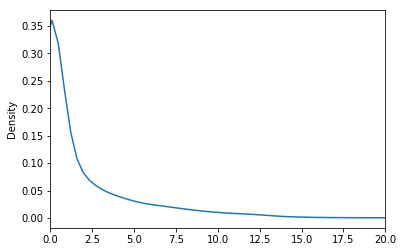

In [201]:
# distribution of number of participants (what we want to predict)
data.R.plot(kind='kde', xlim=[0,20])

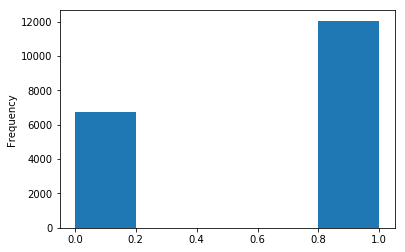

In [202]:
# distribution of canceled 
# => 2/3 are canceled
data.Storno.plot(kind='hist', bins=5)

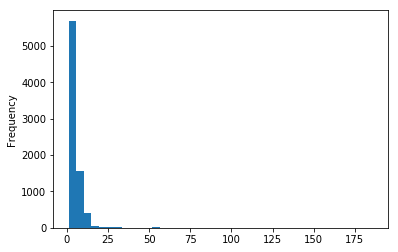

In [203]:
# distribution of number of participants without 0
# still very skewed
data[data.R > 0.].R.plot(kind='hist', bins=40)

In [204]:
###########  data cleaning done ##########

In [205]:
from sklearn.model_selection import train_test_split
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.linear_model import LinearRegression

Now we predicted a probability of 85% that our model above is correct. Then we tried to improve our prediction by adding additional features (Bereich, Gruppe, GDP), but it turned out that the prediction only has a very little difference. (Both values = around 0,85) Therefore, our features turned out to be useless for our prediction and did not go any further in this analysis.

In [206]:
#### try classification into canceled and not canceled ###

In [207]:
# try classification 4 weeks before the seminar
X = data.drop(['R7', 'R14', 'R21', 'R', 'Storno', ], axis=1).values
y = data.Storno.values

In [208]:
### KFold random forest ###
def RF(X, y):
    reg = RandomForestClassifier(n_estimators=100, n_jobs=4)
    avg_score = 0.
    for train, test in KFold(n_splits=5).split(X):
        X_test, X_train =  X[test], X[train] 
        y_test, y_train =  y[test], y[train]
        reg.fit(X_train,y_train)
        avg_score += reg.score(X_test,y_test)/5.
    return avg_score

In [209]:
RF(X, y)

0.853655942568466

In [210]:
# try using only R features 
data.columns[1:24]

Index(['R182', 'R175', 'R168', 'R161', 'R154', 'R147', 'R140', 'R133', 'R126',
       'R119', 'R112', 'R105', 'R98', 'R91', 'R84', 'R77', 'R70', 'R63', 'R56',
       'R49', 'R42', 'R35', 'R28'],
      dtype='object')

In [211]:
X = data[data.columns[1:24]].values
y = data.Storno.values

In [212]:
RF(X, y)
# same value => looks like other features are useless

0.85663387396968904

In row 82 we gradually dropped each column starting at R182 and looked at how the prediction developed over time after successively dropping one column each time. Below a trend line is depicted showing that development.

In [213]:
# reduce columns and keep score
scores_RF = list()
for i in range(2,24):
    X = data[data.columns[1:i]].values
    scores_RF.append(RF(X, y))

In [214]:
import matplotlib.pyplot as plt

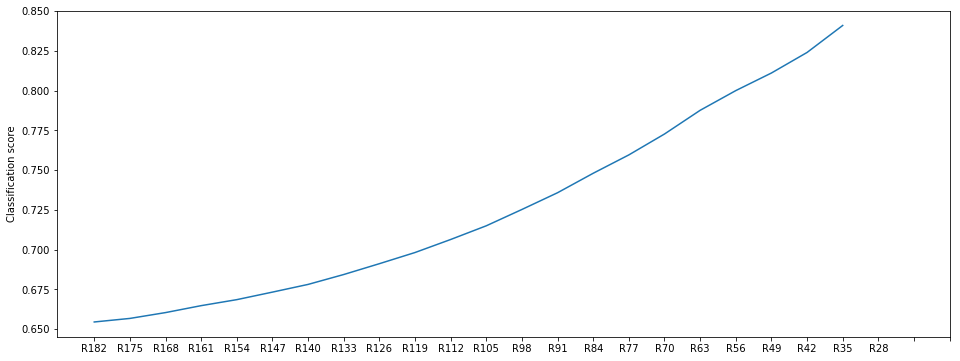

In [215]:
plt.figure(figsize=(16,6))
plt.plot(scores_RF)
plt.xticks(np.arange(25), data.columns[1:24].values)
plt.ylabel('Classification score')
plt.show()

In [216]:
data.columns[1:24].values

array(['R182', 'R175', 'R168', 'R161', 'R154', 'R147', 'R140', 'R133',
       'R126', 'R119', 'R112', 'R105', 'R98', 'R91', 'R84', 'R77', 'R70',
       'R63', 'R56', 'R49', 'R42', 'R35', 'R28'], dtype=object)

In [217]:
# try classification 4 weeks before the seminar
X = data.drop(['R7', 'R14', 'R21', 'R', 'Storno', ], axis=1).values
y = data.R.values

In [218]:
from sklearn.linear_model import LinearRegression

In [219]:
### KFold linear regression ###

def LR(X, y):
    reg = LinearRegression()
    avg_score = 0.
    for train, test in KFold(n_splits=5).split(X):
        X_test, X_train =  X[test], X[train] 
        y_test, y_train =  y[test], y[train]
        reg.fit(X_train,y_train)
        avg_score += reg.score(X_test,y_test)/5.
    return avg_score

In [220]:
LR(X, y)

0.56692971909287515

The graph below looks at the number of participants’ registrations over time and it shows a sudden surge around 6-7 weeks before the course start. This might be due to the course guarantee that they usually have around the same time in advance. We think that the participants rather want to register for a course with a guarantee.

In [221]:
# reduce columns and keep score
scores_LR = list()
for i in range(2,25):
    X = data[data.columns[1:i]].values
    scores_LR.append(LR(X, y))

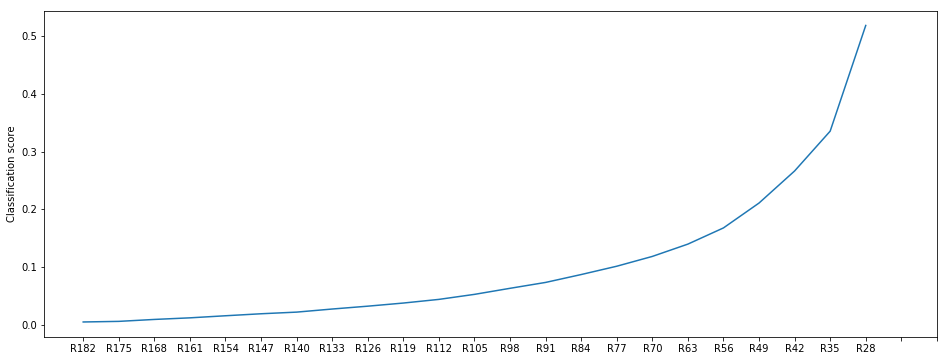

In [222]:
plt.figure(figsize=(16,6))
plt.plot(scores_LR)
plt.xticks(np.arange(25), data.columns[1:24].values)
plt.ylabel('Classification score')
plt.show()